# DRL_PFOpt_XP - SAC Training Tests
#### 2022/11/06, AJ Zerouali

Goals:

* Implement and test new features for the environment and agent classes of *DRL_PFOpt*.
* Find adequate parameters for the training of a SAC agent for portfolio optimization

## Imports and Dow Jones Data

In [1]:
# Kill warnings
from warnings import filterwarnings
filterwarnings("ignore")

### Basics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
%matplotlib inline
import datetime
import itertools

### OpenAI Gym and StableBaselines3
from gym.utils import seeding
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

### What is this?
import sys

### My imports (22/11/04, AJ Zerouali)
import DRL_PFOpt_Utils
import DRL_PFOpt_Data
import DRL_PFOpt_gymEnv
import DRL_PFOpt_Agent

# Experimental implementations
from DRL_PFOpt_XP import PFOptAgent_XP, PFOptEnv_XP

# Load Dow Jones data
df_file = pd.read_csv(filepath_or_buffer="datasets/DJIA30_data_0801-0908.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

# Instantiate feature engineering object
FeatureEng = DRL_PFOpt_Data.FeatureEngineer(tech_indicator_list = ["turbulence"],
                                                 use_return_covs = True,
                                                 n_lookback_prds = 90)

# Preprocess df_file
df_X, np_close_returns, np_returns_cov = FeatureEng.preprocess_data(df_X = df_file)

Successfully computed asset returns and their covariances
Successfully added technical indicators
Successfully added turbulence index


In [2]:
# Train and test dates
start_train_date = '2008-12-31'
end_train_date = '2020-07-01'
start_test_date = end_train_date
end_test_date = '2021-09-02'

In [3]:
df_train, ret_X_train, cov_X_train = DRL_PFOpt_Data.data_split(df_X = df_X, 
                                                                    start=start_train_date, 
                                                                    end = end_train_date,
                                                                    use_returns_cov = True,
                                                                    ret_X= np_close_returns,
                                                                    cov_X=np_returns_cov)

Dataframe, returns and cov have same number of dates


In [4]:
df_test, ret_X_test, cov_X_test = DRL_PFOpt_Data.data_split(df_X = df_X, 
                                                                    start=start_test_date, 
                                                                    end = end_test_date,
                                                                    use_returns_cov = True,
                                                                    ret_X= np_close_returns,
                                                                    cov_X=np_returns_cov)

Dataframe, returns and cov have same number of dates


**Get benchmark data**

Benchmark data (DJIA) over testing dates.

In [5]:
df_DJI_benchmark, df_DJI_returns = DRL_PFOpt_Utils.get_benchmark_prices_and_returns(
                    ticker = "^DJI", start_date = '2020-07-01', end_date = '2021-09-02')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (296, 8)


## SAC Baseline training - SftMx Weights

**seed = 169, batch_size=256, ent_coef=0.01, lr = 0.001**

Train:

        =================================
        Initial portfolio value: 1000000
        End portfolio value: 6376776.214726381
        Yearly Sharpe ratio at last period: 0.9587646926979745
        =================================
        
Backtest:

        =================================
        Initial portfolio value: 1000000
        End portfolio value: 1420034.449498455
        Yearly Sharpe ratio at last period: 2.2502140980368104
        =================================
        
**seed = 169, batch_size=256, ent_coef=0, lr = 0.001**

Results are same for testing, slightly different for training.

**seed = 169, batch_size=256, ent_coef=0.1, lr = 0.001**

Same as previous case.

**The portfolio weights take only 2 values here.**

**seed = 169, batch_size=128, ent_coef=0.1, lr = 0.001**

Results of training are very close, they're worse for testing:

        =================================
        Initial portfolio value: 1000000
        End portfolio value: 1389233.4827517525
        Yearly Sharpe ratio at last period: 2.038057208876601
        =================================
        
**seed = 169, batch_size=512, ent_coef=0.1, lr = 0.001**

Training result is slightly lower. Testing results:

        =================================
        Initial portfolio value: 1000000
        End portfolio value: 1407502.6243865439
        Yearly Sharpe ratio at last period: 2.092408440125016
        =================================

In [6]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "softmax"

In [7]:
train_env_sftmx = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [8]:
test_env_sftmx = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [9]:
train_env_sftmx.N_periods

2894

In [42]:
del SAC_Agent_OHCLVW_SftMx

In [9]:
# Instantiate agent
SAC_Agent_OHCLVW_SftMx = PFOptAgent_XP(train_env = train_env_sftmx)

In [10]:

SAC_PARAMS = {
    "batch_size": 256,
    "buffer_size": 100000,
    "learning_rate": 0.001,
    "ent_coef": 0.01,
    "gamma":0,
    "action_noise":"ornstein_uhlenbeck",}

SAC_Agent_OHCLVW_SftMx.set_model(model_name = "sac",
                                seed = 169,
                                model_kwargs=SAC_PARAMS)



{'batch_size': 256, 'buffer_size': 100000, 'learning_rate': 0.001, 'ent_coef': 0.01, 'gamma': 0, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
sac with given parameters has been successfully created.


True

In [11]:
SAC_Agent_OHCLVW_SftMx.train_model(tb_log_name='sac',
                                  n_train_rounds=1)

Initial portfolio value: 1000000
End portfolio value: 6376776.214726381
Yearly Sharpe ratio at last period: 0.9587646926979745


In [12]:
df_pf_value_hist_det, df_pf_return_hist_det, \
df_pf_weights_hist_det, df_agt_action_hist_det\
 = SAC_Agent_OHCLVW_SftMx.run_backtest(test_env = test_env_sftmx,)

Initial portfolio value: 1000000
End portfolio value: 1420034.449498455
Yearly Sharpe ratio at last period: 2.2502140980368104
Finished running backtest. Storing results...


Start date,2020-07-01
End date,2021-09-01
Total months,14
,Backtest
Annual return,34.8%
Cumulative returns,42.0%
Annual volatility,13.7%
Sharpe ratio,2.25
Calmar ratio,3.90
Stability,0.95
Max drawdown,-8.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.92,2020-09-02,2020-10-28,2020-11-09,49
1,3.93,2021-06-04,2021-06-18,2021-07-02,21
2,3.12,2021-01-21,2021-01-29,2021-02-04,11
3,3.10,2021-05-10,2021-05-12,2021-06-04,20
4,3.00,2021-02-24,2021-03-04,2021-03-10,11


Stress Events,mean,min,max
New Normal,0.12%,-3.27%,3.81%


True

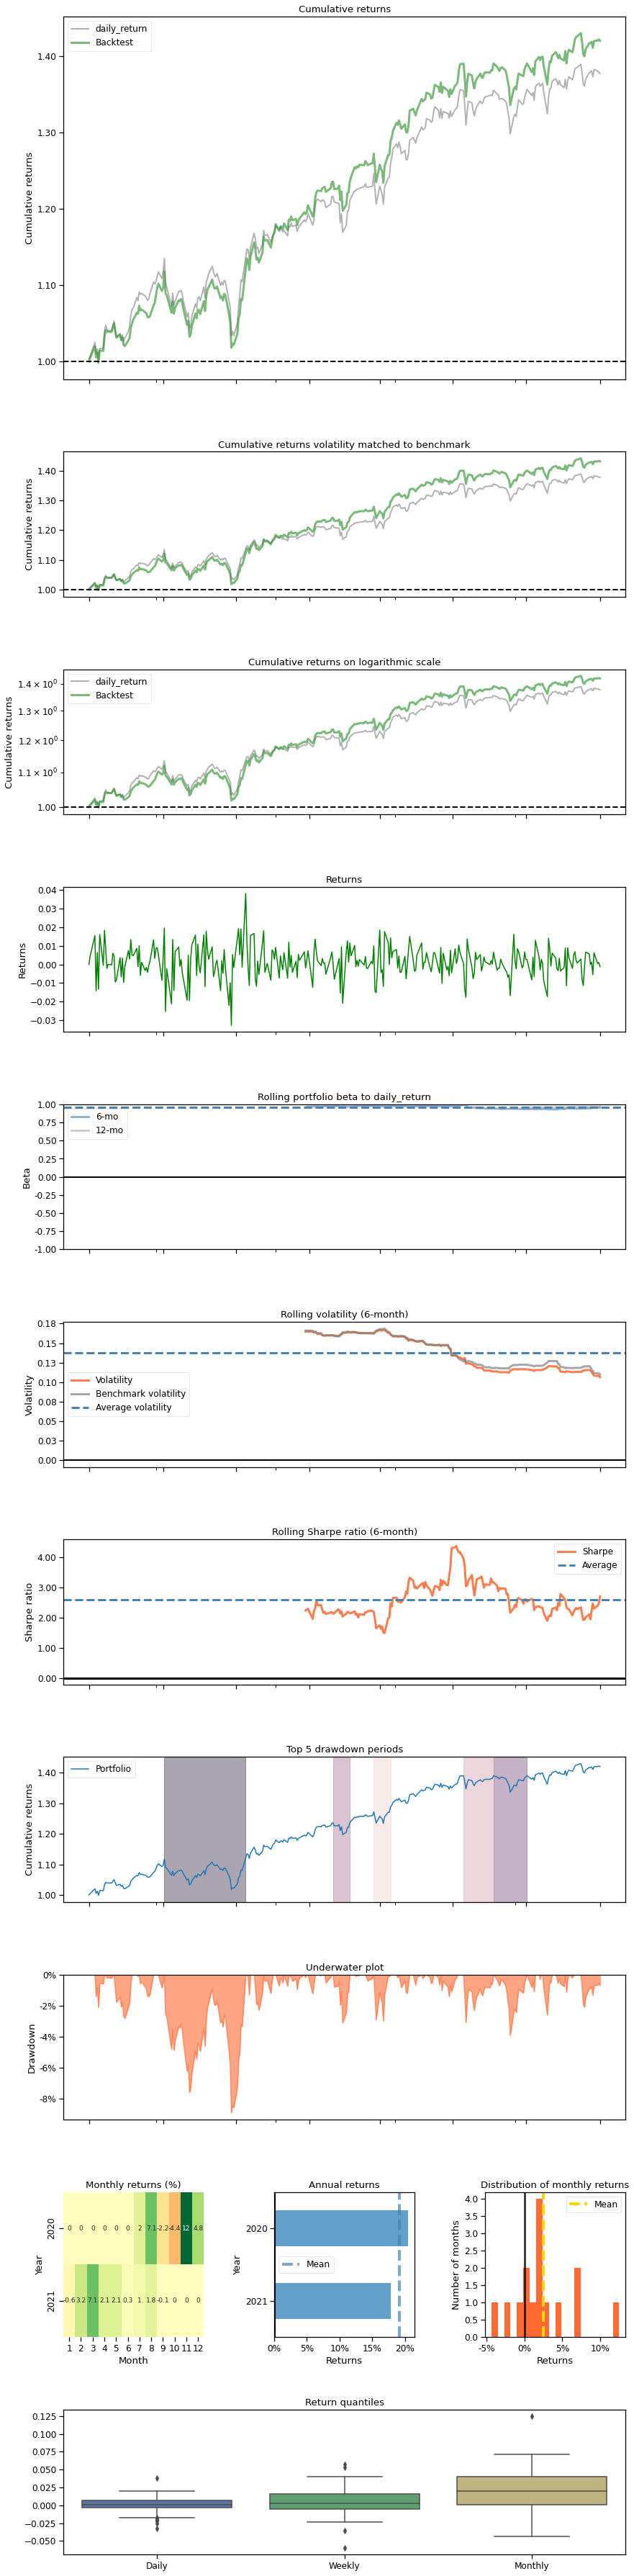

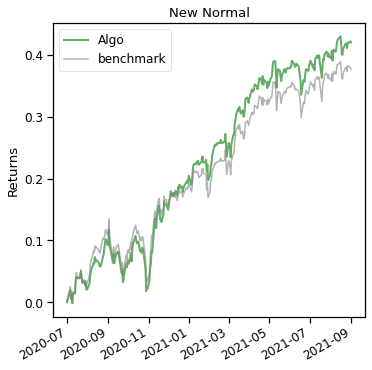

In [13]:
%matplotlib inline
SAC_Agent_OHCLVW_SftMx.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

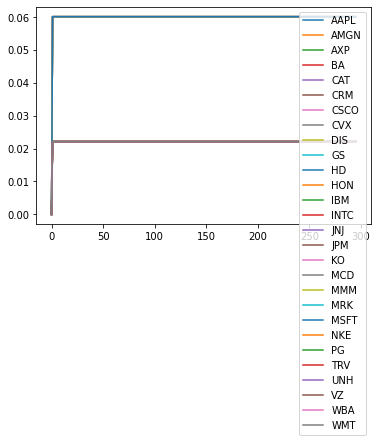

In [14]:
%matplotlib inline
SAC_Agent_OHCLVW_SftMx.pf_weights_hist.plot()

In [ ]:
SAC_Agent_OHCLVW_SftMx.agt_action_hist.plot()

In [15]:
df_DJI_benchmark.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day'], dtype='object')

In [16]:
100*((df_DJI_benchmark['close'].iloc[-1]-df_DJI_benchmark['close'].iloc[0]) \
     /df_DJI_benchmark['close'].iloc[0])

37.216131533081544

In [19]:
df_DJI_returns.columns

Index(['date', 'daily_return'], dtype='object')

In [23]:
DJI_returns = df_DJI_returns['daily_return'].to_numpy()

In [24]:
np.sqrt(252)*(DJI_returns.mean()/DJI_returns.std())

2.015785699745866

In [17]:
df_DOW_benchmark, df_DOW_returns = DRL_PFOpt_Utils.get_benchmark_prices_and_returns(
                    ticker = "DOW", start_date = '2020-07-01', end_date = '2021-09-02')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (296, 8)


In [18]:
100*((df_DOW_benchmark['close'].iloc[-1]-df_DOW_benchmark['close'].iloc[0]) \
     /df_DOW_benchmark['close'].iloc[0])

62.91240458156494

## Seed testing

Will loop over a set of seeds. For training Sharpe ratios over 0.93, we'll record the training Sharpe ratio, the testing Sharpe, and the final portfolio value.

In [6]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "softmax"

In [7]:
train_env_sftmx = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [8]:
test_env_sftmx = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [9]:
SAC_PARAMS = {
    "batch_size": 256,
    "buffer_size": 100000,
    "learning_rate": 0.001,
    "ent_coef": 0.01,
    "gamma":0,
    #"action_noise":"ornstein_uhlenbeck",
}

In [13]:
del SAC_Agent_OHCLVW_SftMx

In [14]:
# Instantiate agent
SAC_Agent_OHCLVW_SftMx = PFOptAgent_XP(train_env = train_env_sftmx)

**Main loop:**

In [11]:
#Initializations
seed_list = []
train_Sharpe_list = []
train_final_val_list = []
test_Sharpe_list = []
test_cumul_return_list = []


In [ ]:
#for seed in range(2):
for seed in range(201):
    print("################")
    print(f"### SEED = {seed} ###")
    print("################")
    # Delete previous agent and make new
    del SAC_Agent_OHCLVW_SftMx
    SAC_Agent_OHCLVW_SftMx = PFOptAgent_XP(train_env = train_env_sftmx)
    
    # Create TD3 agent with current seed and params above
    SAC_Agent_OHCLVW_SftMx.set_model(model_name = "sac",
                                seed = seed,
                                model_kwargs=SAC_PARAMS)
    print("==================================================================")
    
    # Train model for 1 round
    print("Training model")
    SAC_Agent_OHCLVW_SftMx.train_model(tb_log_name='sac',
                                  n_train_rounds=1)
    
    # Get approximate training Sharpe ratio
    df_pf_value_hist_tr, df_pf_return_hist_tr, \
    df_pf_weights_hist_tr, df_agt_action_hist_tr\
     = SAC_Agent_OHCLVW_SftMx.run_backtest(test_env = train_env_sftmx,)
    
    train_pf_return_hist = df_pf_return_hist_tr['daily_return'].to_numpy()
    train_Sharpe = ((252**0.5)*train_pf_return_hist.mean())/(train_pf_return_hist.std())
    train_final_val = df_pf_value_hist_tr['daily_value'].iloc[-1]
    
    # Run backtest on test data
    print("Running backtest on test data")
    df_pf_value_hist_ts, df_pf_return_hist_ts, \
    df_pf_weights_hist_ts, df_agt_action_hist_ts\
     = SAC_Agent_OHCLVW_SftMx.run_backtest(test_env = test_env_sftmx,)
    
    # Get test Sharpe ratio and cumulative return
    test_pf_return_hist = df_pf_return_hist_ts['daily_return'].to_numpy()
    test_Sharpe = ((252**0.5)*test_pf_return_hist.mean())/(test_pf_return_hist.std())
    #test_final_pf_value = df_pf_value_hist_ts['daily_value'].iloc[-1]
    test_cumul_return = (df_pf_value_hist_ts['daily_value'].iloc[-1]-pf_value_ini)/pf_value_ini
    print("==================================================================")
    
    # Record seed according to results:
    if (train_Sharpe>=0.94) or (test_Sharpe>=2.15) or (test_cumul_return>=0.43):
        seed_list.append(seed)
        train_Sharpe_list.append(train_Sharpe)
        train_final_val_list.append(train_final_val)
        test_Sharpe_list.append(test_Sharpe)
        test_cumul_return_list.append(test_cumul_return)
        
# Make result dataframe and save to csv
df_results = pd.DataFrame({"Seed":seed_list,
                           "Training final val.":train_final_val_list,
                           "Training Sharpe": train_Sharpe_list,
                           "Test cumul. ret.":test_cumul_return_list,
                           "Test Sharpe": test_Sharpe_list,
                          })
df_results.to_csv("SAC_OHCLVW_SftMx_Seeds_0-200_221106.csv")

################
### SEED = 0 ###
################
{'batch_size': 256, 'buffer_size': 100000, 'learning_rate': 0.001, 'ent_coef': 0.01, 'gamma': 0}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
sac with given parameters has been successfully created.
Training model
Initial portfolio value: 1000000
End portfolio value: 6151819.613473973
Yearly Sharpe ratio at last period: 0.9596994734953849
Initial portfolio value: 1000000
End portfolio value: 5985633.697330079
Yearly Sharpe ratio at last period: 0.93736705785514
Finished running backtest. Storing results...
Running backtest on test data
Initial portfolio value: 1000000
End portfolio value: 1423646.2693273793
Yearly Sharpe ratio at last period: 2.235995396151529
Finished running backtest. Storing results...
################
### SEED = 1 ###
################
{'batch_size': 256, 'buffer_size': 100000, 'learning_rate': 0.001, 'ent_coef': 0.01, 'gamma': 0}
Using cuda device
Wrapping the env w

### Checking results

In [6]:
df_results = pd.read_csv("SAC_OHCLVW_SftMx_Seeds_0-200_221106.csv",
                        usecols = ['Seed', 'Training final val.', 'Training Sharpe', 'Test cumul. ret.', 'Test Sharpe'])

In [7]:
df_results.head()

,Seed,Training final val.,Training Sharpe,Test cumul. ret.,Test Sharpe
0,0,5.985634e+06,0.937367,0.423646,2.235995
1,1,6.499533e+06,0.980981,0.377457,2.022739
2,2,6.177985e+06,0.964845,0.395275,2.159931
3,4,6.352955e+06,0.985061,0.405116,2.215654
4,5,5.828391e+06,0.943609,0.419209,2.192327


**Highest cumul. return:**

In [10]:
df_results['Test cumul. ret.'].argmax()

167

In [23]:
df_results['Seed'].iloc[df_results['Test cumul. ret.'].argmax()]

196

In [8]:
df_results['Test cumul. ret.'].max()

0.4745327230426043

In [9]:
df_results['Test Sharpe'].iloc[df_results['Test cumul. ret.'].argmax()]

2.3415482588935186

**Best Sharpe ratio:**

In [14]:
df_results['Test Sharpe'].argmax()

40

In [11]:
df_results['Test Sharpe'].max()

2.4742658790804746

In [12]:
df_results['Test cumul. ret.'].iloc[df_results['Test Sharpe'].argmax()]

0.4551683153833619

## SAC with best seed - SftMx

In [15]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "softmax"

In [16]:
train_env_sftmx = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [17]:
test_env_sftmx = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [21]:
del SAC_Agent_OHCLVW_SftMx

In [22]:
# Instantiate agent
SAC_Agent_OHCLVW_SftMx = PFOptAgent_XP(train_env = train_env_sftmx)

In [24]:

SAC_PARAMS = {
    "batch_size": 256,
    "buffer_size": 100000,
    "learning_rate": 0.001,
    "ent_coef": 0.01,
    "gamma":0,
    "action_noise":"ornstein_uhlenbeck",
}

SAC_Agent_OHCLVW_SftMx.set_model(model_name = "sac",
                                seed = 196,
                                model_kwargs=SAC_PARAMS)



{'batch_size': 256, 'buffer_size': 100000, 'learning_rate': 0.001, 'ent_coef': 0.01, 'gamma': 0, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
sac with given parameters has been successfully created.


True

In [25]:
SAC_Agent_OHCLVW_SftMx.train_model(tb_log_name='sac',
                                  n_train_rounds=12)

Initial portfolio value: 1000000
End portfolio value: 6253568.0178629495
Yearly Sharpe ratio at last period: 0.946079156003519
Initial portfolio value: 1000000
End portfolio value: 6500464.137904373
Yearly Sharpe ratio at last period: 0.960569189836017
Initial portfolio value: 1000000
End portfolio value: 6523778.440290358
Yearly Sharpe ratio at last period: 0.9609355486365342
Initial portfolio value: 1000000
End portfolio value: 6521160.775889306
Yearly Sharpe ratio at last period: 0.960636614316497
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 2.89e+03    |
|    ep_rew_mean     | 2.08        |
| time/              |             |
|    episodes        | 4           |
|    fps             | 54          |
|    time_elapsed    | 210         |
|    total_timesteps | 11576       |
| train/             |             |
|    actor_loss      | 1.43e+03    |
|    critic_loss     | 2.52e+07    |
|    ent_coef        | 0.01        |
|    learning

In [26]:
df_pf_value_hist, df_pf_return_hist, \
df_pf_weights_hist, df_agt_action_hist\
 = SAC_Agent_OHCLVW_SftMx.run_backtest(test_env = test_env_sftmx,)

Initial portfolio value: 1000000
End portfolio value: 1474532.7230426043
Yearly Sharpe ratio at last period: 2.3415482588935186
Finished running backtest. Storing results...


Start date,2020-07-01
End date,2021-09-01
Total months,14
,Backtest
Annual return,39.2%
Cumulative returns,47.5%
Annual volatility,14.6%
Sharpe ratio,2.34
Calmar ratio,4.67
Stability,0.96
Max drawdown,-8.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.39,2020-09-02,2020-10-28,2020-11-09,49
1,4.33,2021-06-04,2021-06-18,2021-07-02,21
2,3.46,2021-01-20,2021-01-29,2021-02-04,12
3,3.24,2021-02-24,2021-03-04,2021-03-10,11
4,3.13,2021-05-07,2021-05-12,2021-06-02,19


Stress Events,mean,min,max
New Normal,0.14%,-3.39%,4.39%


True

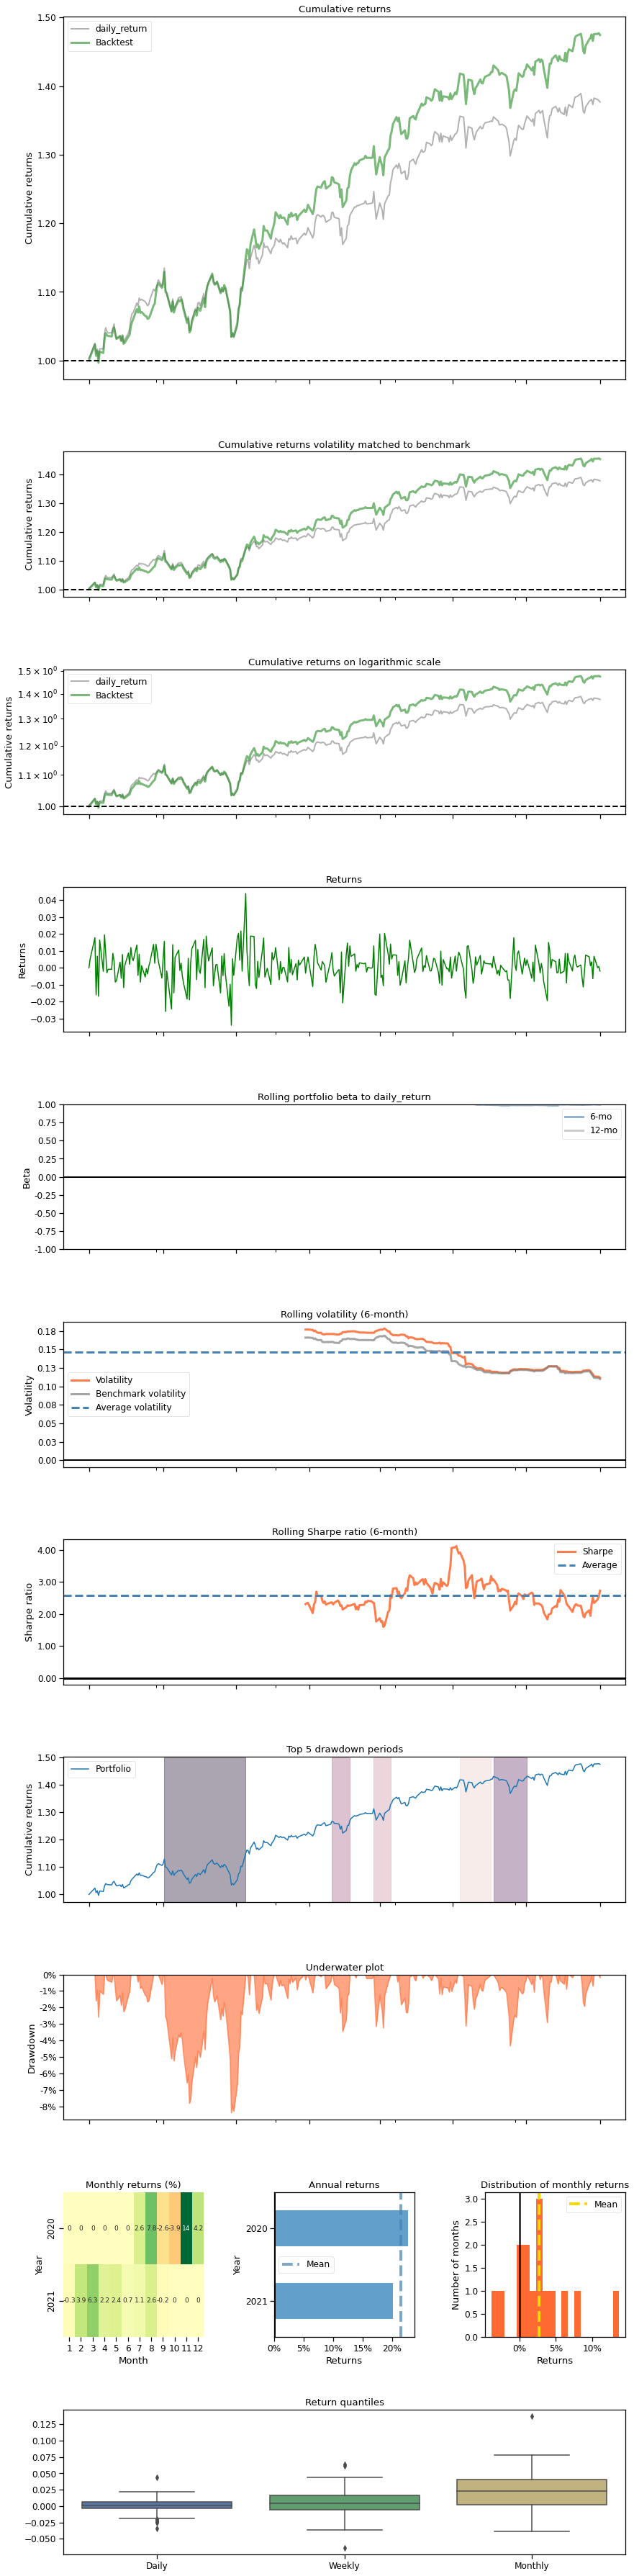

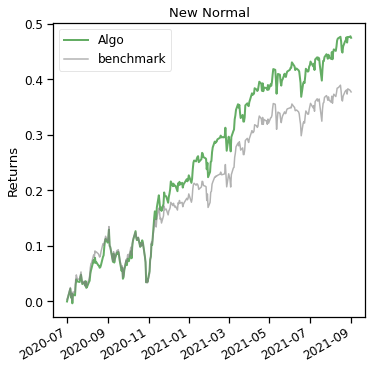

In [27]:
%matplotlib inline
SAC_Agent_OHCLVW_SftMx.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

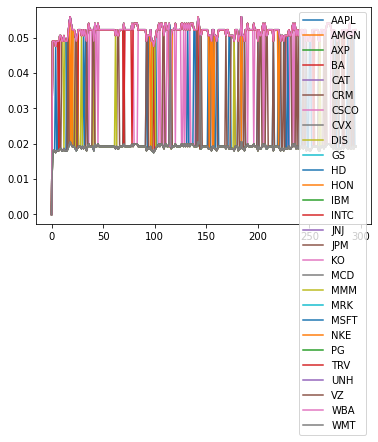

In [28]:
SAC_Agent_OHCLVW_SftMx.pf_weights_hist.plot()

## SAC with best seed - Normalized ReLU

In [29]:
# Env params
n_lookback_prds = 90
pf_value_ini = 1000000
reward_type= 'portfolio_return'
state_struct_list = ['open','high','low','close', 'volume', 'weights']
tech_ind_list = []
transaction_cost_pct = 0
weight_normalization = "relu"

In [30]:
train_env_relu = PFOptEnv_XP(
            df_X = df_train,
            cov_X = cov_X_train,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [31]:
test_env_relu = PFOptEnv_XP(
            df_X = df_test,
            cov_X = cov_X_test,
            n_lookback_prds = n_lookback_prds,
            pf_value_ini = pf_value_ini,
            reward_type = reward_type,
            state_struct_list = state_struct_list,
            tech_ind_list = tech_ind_list,
            transaction_cost_pct= transaction_cost_pct,
            weight_normalization = weight_normalization)

In [21]:
del SAC_Agent_OHCLVW_SftMx

In [32]:
# Instantiate agent
SAC_Agent_OHCLVW_ReLU = PFOptAgent_XP(train_env = train_env_relu)

In [33]:

SAC_PARAMS = {
    "batch_size": 256,
    "buffer_size": 100000,
    "learning_rate": 0.001,
    "ent_coef": 0.01,
    "gamma":0,
    "action_noise":"ornstein_uhlenbeck",
}

SAC_Agent_OHCLVW_ReLU.set_model(model_name = "sac",
                                seed = 196,
                                model_kwargs=SAC_PARAMS)



{'batch_size': 256, 'buffer_size': 100000, 'learning_rate': 0.001, 'ent_coef': 0.01, 'gamma': 0, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
sac with given parameters has been successfully created.


True

In [34]:
SAC_Agent_OHCLVW_ReLU.train_model(tb_log_name='sac',
                                  n_train_rounds=12)

Initial portfolio value: 1000000
End portfolio value: 6232817.588866008
Yearly Sharpe ratio at last period: 0.917208597322507
Initial portfolio value: 1000000
End portfolio value: 6743914.860800497
Yearly Sharpe ratio at last period: 0.9450583441657842
Initial portfolio value: 1000000
End portfolio value: 6841345.34235895
Yearly Sharpe ratio at last period: 0.9494590803327266
Initial portfolio value: 1000000
End portfolio value: 6767906.342464431
Yearly Sharpe ratio at last period: 0.9459449535210304
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 2.89e+03    |
|    ep_rew_mean     | 2.13        |
| time/              |             |
|    episodes        | 4           |
|    fps             | 54          |
|    time_elapsed    | 211         |
|    total_timesteps | 11576       |
| train/             |             |
|    actor_loss      | 2.06e+03    |
|    critic_loss     | 1.72e+07    |
|    ent_coef        | 0.01        |
|    learning

In [35]:
df_pf_value_hist, df_pf_return_hist, \
df_pf_weights_hist, df_agt_action_hist\
 = SAC_Agent_OHCLVW_ReLU.run_backtest(test_env = test_env_relu,)

Initial portfolio value: 1000000
End portfolio value: 1551576.585764786
Yearly Sharpe ratio at last period: 2.463998889368824
Finished running backtest. Storing results...


Start date,2020-07-01
End date,2021-09-01
Total months,14
,Backtest
Annual return,45.4%
Cumulative returns,55.2%
Annual volatility,15.7%
Sharpe ratio,2.46
Calmar ratio,5.33
Stability,0.96
Max drawdown,-8.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.51,2020-10-12,2020-10-28,2020-11-09,21
1,8.30,2020-09-02,2020-09-23,2020-10-12,29
2,4.84,2021-06-04,2021-06-18,2021-07-02,21
3,3.37,2021-01-20,2021-01-29,2021-02-04,12
4,3.29,2021-02-24,2021-03-04,2021-03-10,11


Stress Events,mean,min,max
New Normal,0.15%,-3.54%,5.08%


True

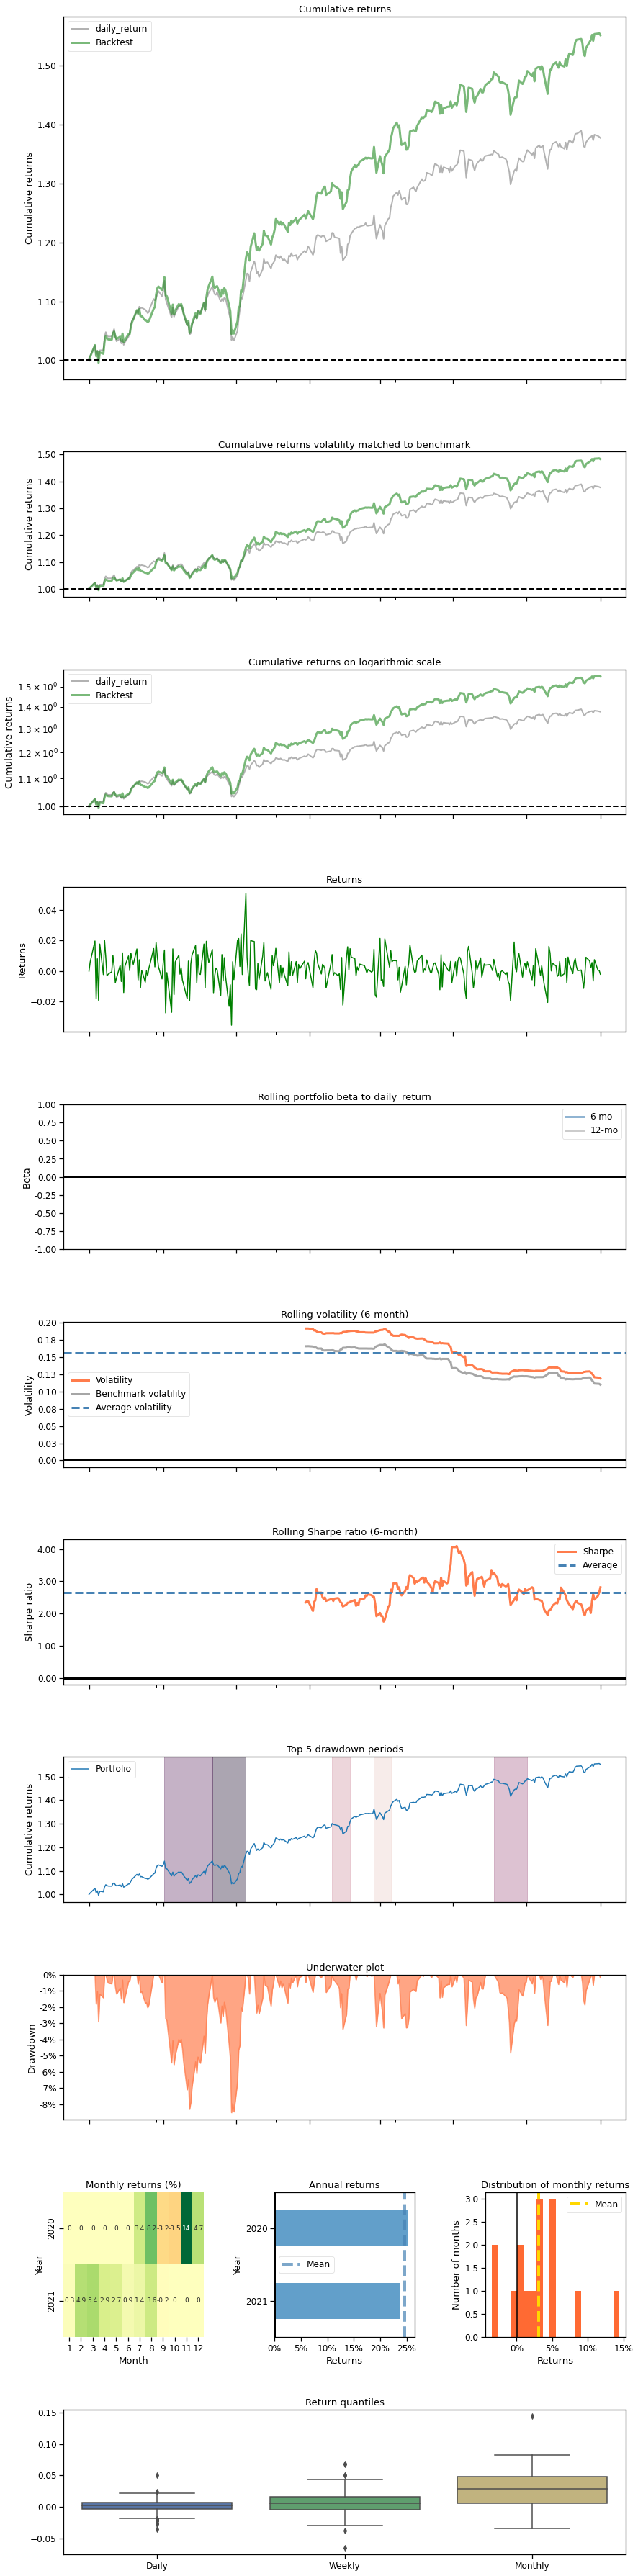

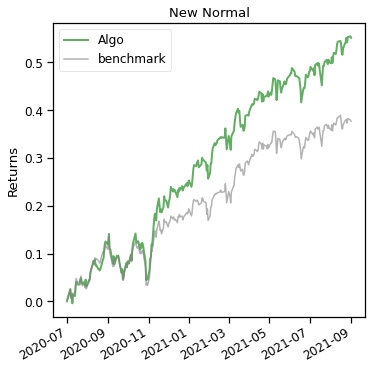

In [36]:
%matplotlib inline
SAC_Agent_OHCLVW_ReLU.plot_backtest_results(df_benchmark_returns=df_DJI_returns)

<AxesSubplot:>

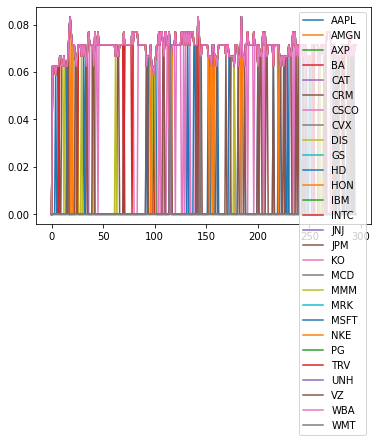

In [37]:
SAC_Agent_OHCLVW_ReLU.pf_weights_hist.plot()